# Predicting the Outcomes of COVID-19 Cases



Importing packages/libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import geopy
import certifi
import ssl
import copy
import csv
from geopy.geocoders import Nominatim

from urllib.parse import urlparse

from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE

# cases_train = pd.read_csv("cases_2021_train_processed_2.csv")
# cases_test = pd.read_csv("cases_2021_test_processed_unlabelled_2.csv")

# Using the Cleaned Datafiles as input:
cases_train = pd.read_csv("cleaned_train_df.csv")
cases_test = pd.read_csv("cleaned_test_df.csv")

## Data Preprocessing --> Imputting Null Provinces, DON'T RUN THIS
```
*   "cleaned_train_df.csv"
*   "cleaned_test_df.csv"
```


In [ ]:
#Missing values for trainning data
print("training data:")
print("province has ", cases_train.province.isna().sum(), ' missing values')
print("test data:")
print("province has ", cases_test.province.isna().sum(), ' missing values')

training data:
province has  2  missing values
test data:
province has  1  missing values


In [ ]:
import geopy
from geopy.geocoders import Nominatim
import certifi
import ssl
import copy
from urllib.parse import urlparse

ctx = ssl.create_default_context(cafile=certifi.where())
geopy.geocoders.options.default_ssl_context = ctx
geopy.geocoders.options.default_user_agent = "cmpt459"

geolocator = Nominatim(timeout= None)

def impute_missing_provinces(df):
  cleaned_df = copy.deepcopy(df)
  
  for index, row in cleaned_df[cleaned_df.province.isna() == True].iterrows():
    
    lat = str(row.latitude)
    lon = str(row.longitude)
    
    if 'nan' not in (lat or lon):
      coordinate = lat + "," + lon
      # check for nan provinces
      if str(row.province) == "nan":
        location = geolocator.reverse(coordinate, language="en")
        # modify province attribute when address is not none
        if location is not None:
          add_lst = location.address.split(', ')
          if len(add_lst) < 2:
            cleaned_df.province[index] = add_lst[0]
          elif len(add_lst) > 2:
            cleaned_df.province[index] = add_lst[-3]
  return cleaned_df
cleaned_test_df = impute_missing_provinces(cases_test)
cleaned_train_df = impute_missing_provinces(cases_train)

#Missing values for trainning data
print("training data:")
print("province has ", cleaned_train_df.province.isna().sum(), ' missing values')
print("test data:")
print("province has ", cleaned_test_df.province.isna().sum(), ' missing values')

# cleaned_train_df=cleaned_train_df.dropna(subset=['province'])

# store to csv
cleaned_train_df.to_csv("cleaned_train_df.csv", index=None)
cleaned_test_df.to_csv("cleaned_test_df.csv", index=None)

training data:
province has  2  missing values
test data:
province has  1  missing values


## 1.1 Feature Selection

Added a feature that combines the province and country features.

In [ ]:
cases_train['province_and_country'] = cases_train['province'] + ", "+ cases_train['country']
cases_test['province_and_country'] = cases_test['province'] + ", "+ cases_test['country']

## 1.2  Mapping the features



In [ ]:
# Using the Cleaned Datafiles as input:
cases_train = pd.read_csv("cleaned_train_df.csv")
cases_test = pd.read_csv("cleaned_test_df.csv")

In [ ]:
# encoding categorical data
def encode_categorical_data(df):
  categorical_data = df.select_dtypes([object])
  df['chronic_disease_binary'] = df['chronic_disease_binary'].astype(int)
  for col in categorical_data:
    s=0
    if col == "date_confirmation":
      df[col] = pd.to_datetime(df[col]).map(datetime.datetime.toordinal)
    if df[col].dtype.name == "object":
      df[col] = pd.Categorical(df[col])
      df[col] = df[col].cat.codes
  return df

In [ ]:
# mapping the trained data
mapped_df = cases_train.copy()
mapped_df = encode_categorical_data(mapped_df)

# mapping the test data
mapped_df1 = encode_categorical_data(cases_test)

## 1.3 Balancing the classes in the training dataset

> Oversampling is performed within 1.4 using SMOTE() with imblearn.pipeline:

> GirdSearchCV splits the into train and validation already, using piping SMOTE() automatically balances the data when it splits everytime

## 1.4 Building models and hyperparameter tuning

definition for creating the submission file

In [ ]:
def create_submission_file(test_pred, file_name):
  with open(file_name, 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction"])
    for i, pred in enumerate(test_pred):
      wr.writerow([str(i), str(pred)])

### 1.4.1 SVM Model

In [ ]:
pipe = Pipeline([('scaler', StandardScaler(copy=True)),
    ('resample', SMOTE()),
    ('model', SVC(random_state=42))])

X_train = mapped_df.copy().drop(columns=['outcome_group'])
y_train = mapped_df.copy()['outcome_group']

scoring = {'accuracy': make_scorer(accuracy_score),
           'f1': make_scorer(f1_score, average='macro'),
           'f1_deceased': make_scorer(f1_score, labels=[0], average='macro'),
           'f1_hospitalized': make_scorer(f1_score, labels=[1], average='macro'),
           'f1_nonhospitalized': make_scorer(f1_score, labels=[2], average='macro')     
           }

kf = StratifiedKFold(n_splits=6, shuffle=True)
param={
    "model__C": np.arange(1,10),
    "model__gamma": [0.01]
}
grid = GridSearchCV(estimator=pipe,
                param_grid=param,
                scoring=scoring,
                refit='accuracy',
                verbose = 2,
                cv=kf, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)
print('best params: ', grid.best_params_)
print('best mean_test_f1: ',grid.cv_results_['mean_test_f1'][grid.best_index_])
print('best mean_test_f1_deceased: ',grid.cv_results_['mean_test_f1_deceased'][grid.best_index_])
print('best mean_test_accuracy: ',grid.cv_results_['mean_test_accuracy'][grid.best_index_])
print('best mean_test_f1_nonhospitalized: ',grid.cv_results_['mean_test_f1_nonhospitalized'][grid.best_index_])
print('best mean_test_accuracy: ',grid.cv_results_['mean_test_accuracy'][grid.best_index_])

print('best mean_train_f1: ',grid.cv_results_['mean_train_f1'][grid.best_index_])
print('best mean_train_f1_deceased: ',grid.cv_results_['mean_train_f1_deceased'][grid.best_index_])
print('best mean_train_accuracy: ',grid.cv_results_['mean_train_accuracy'][grid.best_index_])
print('best mean_test_f1_nonhospitalized: ',grid.cv_results_['mean_test_f1_nonhospitalized'][grid.best_index_])
print('best mean_test_accuracy: ',grid.cv_results_['mean_test_accuracy'][grid.best_index_])


### 1.4.2 Random Forest Classification Model

#### 1.4.2a Initialize Hyper-parameters and Build Random Forest Classifier

In [ ]:
pipe = Pipeline([('resample', SMOTE()), ('model', RandomForestClassifier(random_state=42))])

X_train = mapped_df.copy().drop(columns=['outcome_group'])
y_train = mapped_df.copy()['outcome_group']

scoring = {'accuracy': make_scorer(accuracy_score),
           'f1': make_scorer(f1_score, average='macro'),
           'f1_deceased': make_scorer(f1_score, labels=[0], average='macro'),
           'f1_hospitalized': make_scorer(f1_score, labels=[1], average='macro'),
           'f1_nonhospitalized': make_scorer(f1_score, labels=[2], average='macro')     
           }

param_grid_rf={
    "model__n_estimators": [30,60,100,300,650,750,850],
    "model__max_depth": np.arange(80,141,20),
    "model__min_samples_split":[2],
    "model__min_samples_leaf": [2,3],
    "model__ccp_alpha": [0.00001],
    "model__max_features": ['log2'],
}
kf = StratifiedKFold(n_splits=10, shuffle=True)

grid_search_rf = GridSearchCV(estimator=pipe,
                param_grid=param_grid_rf,
                scoring=scoring,
                refit='accuracy',
                verbose = 0,
                cv=kf, n_jobs=-1, return_train_score=True)

#### 1.4.2b Fit on Train data and Output Results


> Best estimator's test and train scores, and a plot of validation and training curves are outputted



Fit and Print Scores

In [ ]:
grid_search_rf.fit(X_train, y_train)
print('best params: ', grid_search_rf.best_params_)
print('best mean_test_f1: ',grid_search_rf.cv_results_['mean_test_f1'][grid_search_rf.best_index_])
print('best mean_test_f1_deceased: ',grid_search_rf.cv_results_['mean_test_f1_deceased'][grid_search_rf.best_index_])
print('best mean_test_f1_hospitalized: ',grid_search_rf.cv_results_['mean_test_f1_hospitalized'][grid_search_rf.best_index_])
print('best mean_test_f1_nonhospitalized: ',grid_search_rf.cv_results_['mean_test_f1_nonhospitalized'][grid_search_rf.best_index_])
print('best mean_test_accuracy: ',grid_search_rf.cv_results_['mean_test_accuracy'][grid_search_rf.best_index_])

print('best mean_train_f1: ',grid_search_rf.cv_results_['mean_train_f1'][grid_search_rf.best_index_])
print('best mean_train_f1_deceased: ',grid_search_rf.cv_results_['mean_train_f1_deceased'][grid_search_rf.best_index_])
print('best mean_train_f1_hospitalized: ',grid_search_rf.cv_results_['mean_train_f1_hospitalized'][grid_search_rf.best_index_])
print('best mean_train_f1_nonhospitalized: ',grid_search_rf.cv_results_['mean_train_f1_nonhospitalized'][grid_search_rf.best_index_])
print('best mean_train_accuracy: ',grid_search_rf.cv_results_['mean_train_accuracy'][grid_search_rf.best_index_])

best params:  {'model__ccp_alpha': 1e-05, 'model__max_depth': 100, 'model__max_features': 'log2', 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 650}
best mean_test_f1:  0.7783571540034184
best mean_test_f1_deceased:  0.4858000395170077
best mean_test_f1_hospitalized:  0.9800315558575796
best mean_test_f1_nonhospitalized:  0.8692398666356681
best mean_test_accuracy:  0.9290023964404996
best mean_train_f1:  0.9144996662189101
best mean_train_f1_deceased:  0.793529972005747
best mean_train_f1_hospitalized:  0.9893592726073044
best mean_train_f1_nonhospitalized:  0.9606097540436791
best mean_train_accuracy:  0.9721899418971651


Plot Training and Validation Curves using n_estimators and Mean F1-score

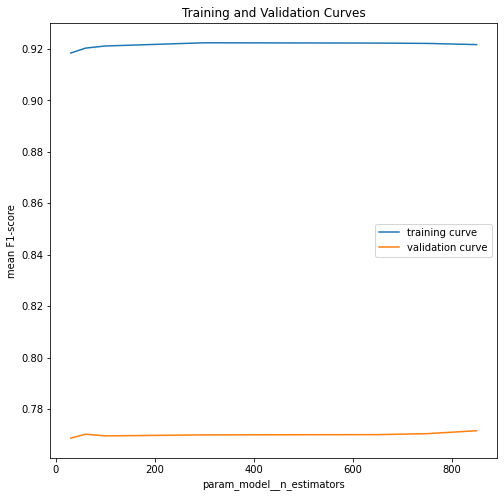

In [ ]:
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
plt.figure(figsize=(8, 8))
sns.lineplot(x='param_model__n_estimators', y='mean_train_f1', data=cv_results_rf, ci=None)
sns.lineplot(x='param_model__n_estimators', y='mean_test_f1', data=cv_results_rf, ci=None)
plt.ylabel("mean F1-score")
plt.legend(labels=['training curve','validation curve'])
plt.title("Training and Validation Curves")
plt.show()

In [ ]:
test_pred3 = grid_search_rf.best_estimator_.predict(mapped_df1)
create_submission_file(test_pred3, 'submission3_rf.csv')

#### 1.4.3c Save Results to .txt and .csv files

In [ ]:
mean_f1_rf = grid_search_rf.cv_results_['mean_test_f1']
mean_f1_deceased_rf = grid_search_rf.cv_results_['mean_test_f1_deceased']
mean_accuracy_rf = grid_search_rf.cv_results_['mean_test_accuracy']
params_rf = grid_search_rf.cv_results_['params']
score_data_rf = {"Hyperparameters": params_rf, "Mean F1 Score": mean_f1_rf, 
          "Mean F1-Score on 'deceased'": mean_f1_deceased_rf, "Mean Accuracy": mean_accuracy_rf}
score_data_rf = pd.DataFrame(score_data_rf)
score_data_rf.to_csv(r'RandomForest_tuning.txt',header=score_data_rf.columns, index=None, sep=',')
score_data_rf.to_csv('RandomForest_tuning.csv')

### 1.4.3 k-Nearest Neighbours Model

#### 1.4.3a Build Classifier and GridScan the Params

In [ ]:
sampled_df = trained_df.sample(frac=1)
y_train = sampled_df['outcome_group']
x_train = sampled_df.drop('outcome_group',axis=1)

scoring = {'accuracy': make_scorer(accuracy_score),
           'f1': make_scorer(f1_score, average='macro'),
           'f1_deceased': make_scorer(f1_score, labels=[0], average='macro'),
           'f1_hospitalized': make_scorer(f1_score, labels=[1], average='macro'),
           'f1_nonhospitalized': make_scorer(f1_score, labels=[2], average='macro')     
           }

param_grid = {
    "model__p": [1,2],
    "model__n_neighbors": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    "model__weights": ['uniform','distance']},

pipe = Pipeline([('resample', SMOTE()), ('model', KNeighborsClassifier())])

grid_search = GridSearchCV(pipe, param_grid, scoring=scoring, refit='accuracy', verbose=0,
                    cv=5, n_jobs=-1, return_train_score=True)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
grid_search.best_score_



{'model__n_neighbors': 9, 'model__p': 2, 'model__weights': 'distance'}


0.9738168951791243

#### 1.4.3b print the best mean accuracy, f1 score, f1 deceased and save results to txt file

In [ ]:
print('best params: ', grid_search.best_params_)
print('best mean_test_f1: ',grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
print('best mean_test_f1_deceased: ',grid_search.cv_results_['mean_test_f1_deceased'][grid_search.best_index_])
print('best mean_test_f1_hospitalized: ',grid_search.cv_results_['mean_test_f1_hospitalized'][grid_search.best_index_])
print('best mean_test_f1_nonhospitalized: ',grid_search.cv_results_['mean_test_f1_nonhospitalized'][grid_search.best_index_])
print('best mean_test_accuracy: ',grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])

print('best mean_train_f1: ',grid_search.cv_results_['mean_train_f1'][grid_search.best_index_])
print('best mean_train_f1_deceased: ',grid_search.cv_results_['mean_train_f1_deceased'][grid_search.best_index_])
print('best mean_train_f1_hospitalized: ',grid_search.cv_results_['mean_train_f1_hospitalized'][grid_search.best_index_])
print('best mean_train_f1_nonhospitalized: ',grid_search.cv_results_['mean_train_f1_nonhospitalized'][grid_search.best_index_])
print('best mean_train_accuracy: ',grid_search.cv_results_['mean_train_accuracy'][grid_search.best_index_])

mean_f1_rf = grid_search.cv_results_['mean_test_f1']
mean_f1_deceased_rf = grid_search.cv_results_['mean_test_f1_deceased']
mean_accuracy_rf = grid_search.cv_results_['mean_test_accuracy']
params_rf = grid_search.cv_results_['params']
score_data_rf = {"Hyperparameters": params_rf, "Mean F1 Score": mean_f1_rf, 
          "Mean F1-Score on 'deceased'": mean_f1_deceased_rf, "Mean Accuracy": mean_accuracy_rf}
score_data_rf = pd.DataFrame(score_data_rf)
score_data_rf.to_csv(r'KNN.txt',header=score_data_rf.columns, index=None, sep=',')
score_data_rf.to_csv('KNN_tuning.csv')

best params:  {'model__n_neighbors': 9, 'model__p': 2, 'model__weights': 'distance'}
best mean_test_f1:  0.9671964572939
best mean_test_f1_deceased:  0.9713747634330556
best mean_test_f1_hospitalized:  0.9890515497520868
best mean_test_f1_nonhospitalized:  0.9411630586965577
best mean_test_accuracy:  0.9738168951791243
best mean_train_f1:  0.9981198253121562
best mean_train_f1_deceased:  0.9976835191447538
best mean_train_f1_hospitalized:  0.9982657150758122
best mean_train_f1_nonhospitalized:  0.9984102417159028
best mean_train_accuracy:  0.9980429013710748


#### 1.4.3c Plot the accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


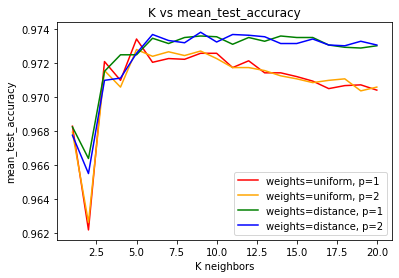

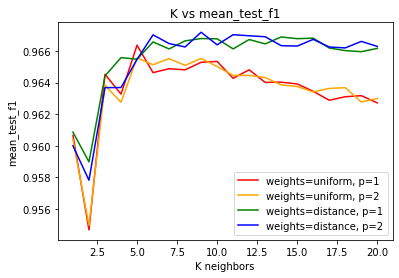

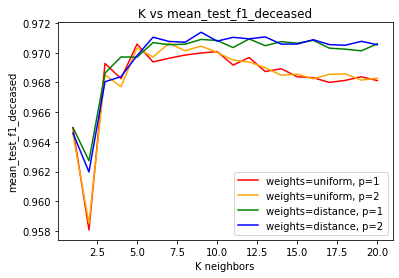

In [ ]:
colors = ['red','orange','green','blue']
yaxes = ["mean_test_accuracy","mean_test_f1","mean_test_f1_deceased"]

df = pd.DataFrame(grid_search.cv_results_)

for yaxis in yaxes:
    fig = plt.figure()
    line = 0
    for weight in param_grid[0]["model__weights"]:
        for p in param_grid[0]["model__p"]:
            #for i,yaxis in enumerate(yaxes):
            #yaxis = "mean_test_accuracy"
            #plt1 = fig.add_subplot(1,3,i+1)
            x1 = param_grid[0]["model__n_neighbors"]
            y1 = list(df[df["param_model__weights"]==weight][df["param_model__p"]==p][yaxis])
            plt.plot(x1,y1,label="weights="+weight+", p="+str(p),color=colors[line])
            plt.title("K vs "+yaxis)
            plt.xlabel("K neighbors")
            plt.ylabel(yaxis)
            plt.legend()
            title = "K vs "+yaxis
            line += 1
        

In [ ]:
best_knn_estimator=grid_search.best_estimator_
y_test_pred = best_knn_estimator.predict(x_test)
y_train_pred = best_knn_estimator.predict(x_train)
print(f1_score(y_test, y_test_pred, average='macro'))
print(f1_score(y_train, y_train_pred, average='macro'))

0.9217968233792829
0.9976712704087863


## 1.7 Prediction on Test Set

In [ ]:
def create_submission_file(y_preds, file_name):
  with open(file_name, 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction"])
    for i, pred in enumerate(y_preds):
      wr.writerow([str(i), str(pred)])

### 1.7.1 Random Forest Model's *Prediction*

In [ ]:
test_pred = grid_search.best_estimator_.predict(mapped_df1)
create_submission_file(test_pred, 'submission_rf.csv')

### 1.7.2 SVM Model's *Prediction*

In [ ]:
test_pred = grid.best_estimator_.predict(mapped_df1)
create_submission_file(test_pred, 'submission_svc.csv')

### 1.7.3 kNN Model's *Prediction*

In [ ]:
# temp = mapped_df1.copy().drop(columns=['province'])
test_pred = best_knn_estimator.predict(mapped_df1)
create_submission_file(test_pred, 'submission_knn.csv')